In [1]:
!pip install caer canaro

     |████████████████████████████████| 838 kB 867 kB/s eta 0:00:01
     |████████████████████████████████| 57.4 MB 23.2 MB/s eta 0:00:01
     |████████████████████████████████| 21.6 MB 51.3 MB/s eta 0:00:01


In [2]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 44 kB/s s eta 0:00:01   |█▊                              | 17.8 MB 814 kB/s eta 0:06:12     |█████████████████████▊          | 216.9 MB 3.6 MB/s eta 0:00:30
     |████████████████████████████████| 459 kB 37.5 MB/s eta 0:00:01
     |████████████████████████████████| 20.1 MB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 24.6 MB/s eta 0:00:01     |█████████████████████████▋      | 20.9 MB 24.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4
  Attempt

In [3]:
import cv2
import numpy as np
import canaro
import caer
import gc
import os
import pandas as pd
import sklearn.model_selection as skm 
import tensorflow as tf


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [6]:
IMG_SIZE = (80,80)

def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder,dir1)):
       
            image_path= os.path.join(img_folder,dir1,file)
            image= cv2.imread(image_path,cv2.COLOR_BGR2RGB)
            if image is None:
                continue
            image=cv2.resize(image,(80,80))
            image=np.array(image)
            image= image.astype('float32')
            image/= 255 
            img_data_array.append(image)
            class_name.append(dir1)
            
    return img_data_array, class_name
# extract the image array and class name
img_data_array, class_name =create_dataset(r'../input/the-simpsons-characters-dataset/simpsons_dataset')

In [7]:
#giving numeric value to each image
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

In [8]:
#numerical encoding the labels of the images 
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]

In [9]:
split_data = skm.train_test_split(img_data_array,target_val, test_size=.3)
x_train, x_test, y_train, y_test = (np.array(item) for item in split_data)

In [ ]:
len(y_train)

In [ ]:
x_train.shape

In [ ]:
len(y_test)

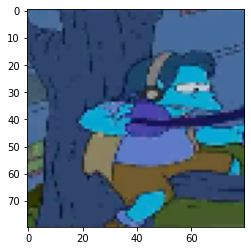

In [10]:
import matplotlib.pyplot as plt

plt.imshow(x_train[110], cmap='gray')
plt.show()

In [11]:
#to save memory delete items we dont need
del img_data_array
del target_val
del class_name
gc.collect

<function gc.collect(generation=2)>

Image data generator (helps generator new images and bring randomness to our data)


Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.
Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images 
that can improve the ability of the fit models to generalize what they have learned to new images.
The Keras deep learning neural network library provides the capability to fit models using image data augmentation via the ImageDataGenerator class.
source:https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/#:~:text=Image%20data%20augmentation%20is%20used,library%20via%20the%20ImageDataGenerator%20class.

In [12]:
#image data generator
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=64)

In [14]:
epochs = 60
batch_size = 64

In [15]:
def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=x_train.shape[1:])) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))
    
    return model

In [16]:
model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='./',verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size,callbacks=[checkpointer,hist], verbose=1)

model.save('model1.h5')

Epoch 1/60
184/184 [==============================] - ETA: 0s - loss: 136.1746 - accuracy: 0.0290
Epoch 00001: val_loss improved from inf to 123.20515, saving model to ./
184/184 [==============================] - 83s 449ms/step - loss: 136.1746 - accuracy: 0.0290 - val_loss: 123.2051 - val_accuracy: 0.0174
Epoch 2/60
184/184 [==============================] - ETA: 0s - loss: 104.1673 - accuracy: 0.0299
Epoch 00002: val_loss improved from 123.20515 to 84.80885, saving model to ./
184/184 [==============================] - 81s 442ms/step - loss: 104.1673 - accuracy: 0.0299 - val_loss: 84.8088 - val_accuracy: 0.0119
Epoch 3/60
184/184 [==============================] - ETA: 0s - loss: 81.9267 - accuracy: 0.0332
Epoch 00003: val_loss improved from 84.80885 to 74.37729, saving model to ./
184/184 [==============================] - 81s 442ms/step - loss: 81.9267 - accuracy: 0.0332 - val_loss: 74.3773 - val_accuracy: 0.0167
Epoch 4/60
184/184 [==============================] - ETA: 0s - loss

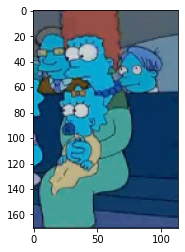

In [29]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/marge_simpson_11.jpg'

img = cv2.imread(test_path)

plt.imshow(img)
plt.show()

In [30]:
def prepare(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, IMG_SIZE)
    #image = caer.reshape(image, (80, 80), 1)
    return np.array([image])

In [31]:
img = cv2.imread(test_path)
img = prepare(img)
print(img.shape)
predictions = model.predict(img)

(1, 80, 80, 3)


In [32]:
for key,value  in target_dict.items(): 
    if value == np.argmax(predictions[0]):
        print(key)

ned_flanders
